# Travelling salesman problem (TSP)
---
**Description**:

- Optimization (combinatorial)
- Single-objective
- Constraints (yes)
---

The travelling salesman problem, asks the following question: Given a list of cities and the distances between each pair of cities,

what is the shortest possible route that visits each city exactly once and returns to the origin city?


https://en.wikipedia.org/wiki/Travelling_salesman_problem

## Step 1: Import python libraries and set up the project directory

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

PROJECT_DIR = os.path.abspath('..')

if PROJECT_DIR not in sys.path:
    sys.path.append(PROJECT_DIR)

## Step 2: Import the custom PSO code

In [2]:
from star_pso.population.swarm import Swarm
from star_pso.utils.auxiliary import BlockType
from star_pso.utils.data_block import DataBlock
from star_pso.population.jat_particle import JatParticle
from star_pso.utils.auxiliary import cost_function
from star_pso.engines.jack_of_all_trades_pso import JackOfAllTradesPSO

### We create a small data structure to hold the city information

In [3]:
# Data structure to represent a city on a grid.
City = namedtuple("City", ["Name", "x", "y"])

### Then we create a list of cities on a grid with (x, y) coordinates

In [4]:
# Define n_cities on a grid [0, 15] x [0, 15]
rome   = City("Rome"  , 3,  2)
athens = City("Athens", 7,  3)
lisbon = City("Lisbon", 14, 2)
madrid = City("Madrid", 3,  7)
berlin = City("Berlin", 12, 7)
paris  = City("Paris" , 2, 14)
london = City("London", 7, 12)
moscow = City("Moscow", 12,12)
dublin = City("Dublin", 6,  9)
cairo  = City("Cairo" , 10, 8)

# Put all the cities in a dictionary.
city_dict = {i: c for i, c in enumerate([rome, athens, lisbon, madrid, berlin,
                                         paris, london, moscow, dublin, cairo])}

### Plot the list of cities

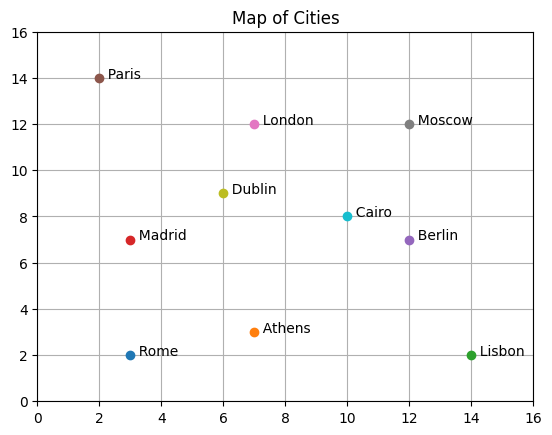

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)

for city in city_dict.values():
    ax.plot(city.x, city.y, 'o')
    ax.annotate(f'  {city.Name}', xy=(city.x, city.y))
# _end_for_

ax.grid()

ax.set_xlim([0, 16])
ax.set_ylim([0, 16])

plt.title("Map of Cities")
plt.show()

## Step 3: Define the objective function

In [6]:
@cost_function(minimize=True)
def fun_tsp(x: np.typing.ArrayLike, **kwargs) -> tuple[float, bool]:
    """
    This function computes the total distance traveled from all cities.
    We assume (hard constraint) that the order that they cities appear
    in the genome list, is the same order the traveler is visiting them.

    When we reach the end of the list we make one extra calculation from
    the last entry of the list to the first: [-1] -> [0].
    """

    # Compute the distance.
    total_distance = 0.0

    # Get the size of the input vector.
    N = len(x)
    
    # Iterate through all the cities.
    for i, n in enumerate(x):
        
        # Get the n-th city in the list.
        city_a = city_dict[n]

        # NOTE: The next index ('j') should point at the
        # beginning of the list once we reach at the end.
        j = i + 1 if i < N-1 else 0

        # Get the next city in the list.
        city_b = city_dict[x[j]]

        # Extract their coordinates.
        x_a, y_a = city_a.x, city_a.y
        x_b, y_b = city_b.x, city_b.y

        # Compute the Euclidean distance.
        total_distance += np.sqrt((x_a - x_b)**2 + ((y_a - y_b)**2))
     
    # _end_for_

    # Condition for termination.
    solution_found = True if total_distance < 49.0 else False
    
    # Return the solution tuple.
    return total_distance, solution_found
# _end_def_

## Step 4: Set the PSO parameters

    - Number of particles 'N'
    - Initial population
    - PSO object
    
**Important note**:

These types of problems (like the TSP) require special crossover/mutation operators for permutations, in order to avoid creating invalid offsprings. The requirement is that all the genes from the initial population have to be present exactly once in the offsprings.

In [7]:
# Define the number of particles.
N = 50

# Define the size of optimizing variables.
D = len(city_dict)

# Define the variable set for the categorical optimization variables.
var_set = list(city_dict.keys())

# Initial swarm population.
swarm_t0 = Swarm([JatParticle([DataBlock(np.ones(D) / D,
                                         BlockType.CATEGORICAL,
                                         valid_set=var_set) for _ in range(D)])
                  for _ in range(N)])

# Create a JackOfAllTradesPSO object that will perform the optimization.
test_PSO = JackOfAllTradesPSO(initial_swarm = swarm_t0,
                              obj_func = fun_tsp,
                              permutation_mode = True)

## Step 5: Run the optimization process

In [8]:
test_PSO.run(max_it = 500,
             options = {"w0": 0.7, "c1": 1.5, "c2": 1.5, "mode": "g_best"},
             reset_swarm = False, verbose = False)

12/18/2025 10:30:52 INFO: Initial f_optimal = -82.1007
12/18/2025 10:30:53 WARNING: JackOfAllTradesPSO found a solution at iteration 58


Final f_optimal = -48.6814
run: elapsed time = 1.861 seconds.


### Display the final solution along with the plot of the cities visited.

In [9]:
# Get the optimal solution from the PSO.
i_opt, f_opt, x_opt = test_PSO.get_optimal_values()

# Display the (final) optimal value.
print(f"Minimum distance: {abs(f_opt)}, at iteration {i_opt}.\n")

Minimum distance: 48.68138249714835, at iteration 58.



### Visualize the solution on a plot map

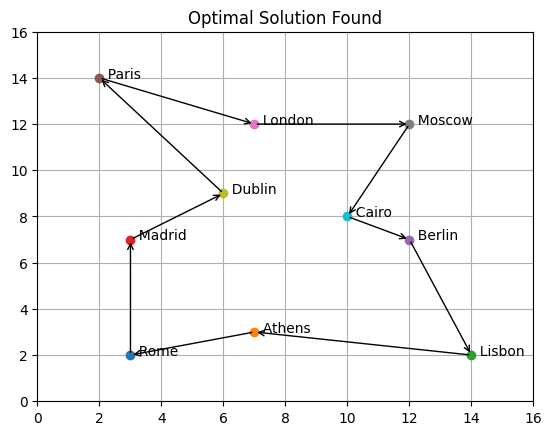

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)

for city in city_dict.values():
    ax.plot(city.x, city.y, 'o')
    ax.annotate(f'  {city.Name}', xy=(city.x, city.y))
# _end_for_

# Get the size of the JatParticle.
N = len(x_opt)

# Iterate through all the cities.
for i, n in enumerate(x_opt):

    city_a = city_dict[n]

    # The next index 'j' should point at the
    # beginning of the list once we reach the end.
    j = i + 1 if i < N-1 else 0

    # Get the next city in the list.
    city_b = city_dict[x_opt[j]]

    # Extract their coordinates.
    x_a, y_a = city_a.x, city_a.y
    x_b, y_b = city_b.x, city_b.y

    # Put the arrow directions.
    ax.annotate("", xy=(x_a, y_a), xytext=(x_b, y_b),
                arrowprops=dict(arrowstyle="<-"))
# _end_for_

ax.grid()

ax.set_xlim([0, 16])
ax.set_ylim([0, 16])

plt.title("Optimal Solution Found")
plt.show()